In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fitam import MAPS_DIR
from fitam.mapping.land_cover_complex_map import LandCoverComplexMap
from fitam.mapping.opengl_scene_rendering import create_scene, render_scene, IMG_HEIGHT_DEG, IMG_HEIGHT_RESOLUTION


import numpy as np 
from PIL import Image
import matplotlib.pyplot as plt 

(128, 4608, 3)


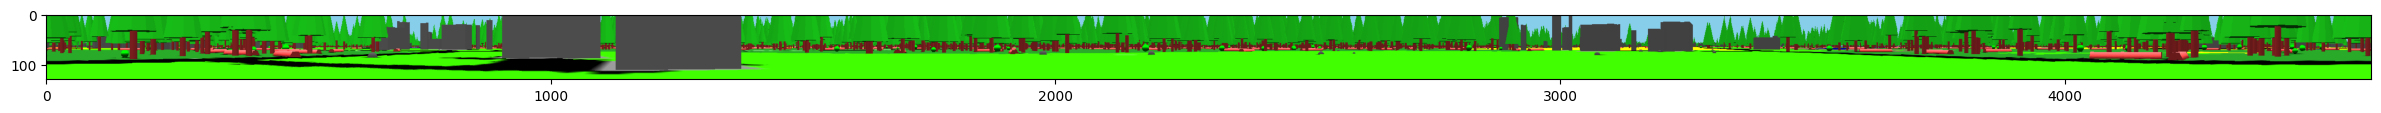

In [3]:
# render a panorama
demo_map_path = MAPS_DIR / 'final_experiment_train_balt' 
demo_map = LandCoverComplexMap.from_map_folder(demo_map_path)
demo_scene = create_scene(demo_map, demo_map_path / 'final_experiment_train_balt.png')
demo_pano = render_scene(demo_scene, [0,0, 1.5], 0.0)
print(demo_pano.shape)
plt.figure(figsize=(30, 5))
plt.imshow(demo_pano)

# Calculate Image Pyramids

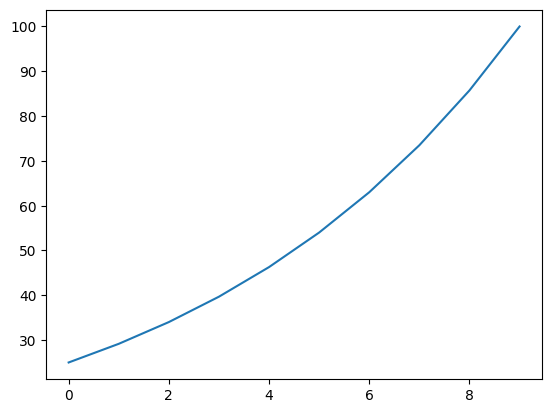

In [4]:
from fitam.mapping.spatial_label_general import ImagePyramidConfig, calculate_footline_distances

plt.figure()
plt.plot(calculate_footline_distances(25, 100, 10))
# def calculate_image_pyramid(image, )

In [5]:
distances = np.array([0.0, 25, 50, 75, 100, 1000, 100000000])
IMG_HEIGHT_RESOLUTION / 2 + ((np.pi / 2 - np.arctan(distances / 1.5)) / np.deg2rad(IMG_HEIGHT_DEG / 2) * IMG_HEIGHT_RESOLUTION / 2)

array([1216.        ,  107.95046864,   85.99498242,   78.66576433,
         74.99996472,   65.10007814,   64.000011  ])

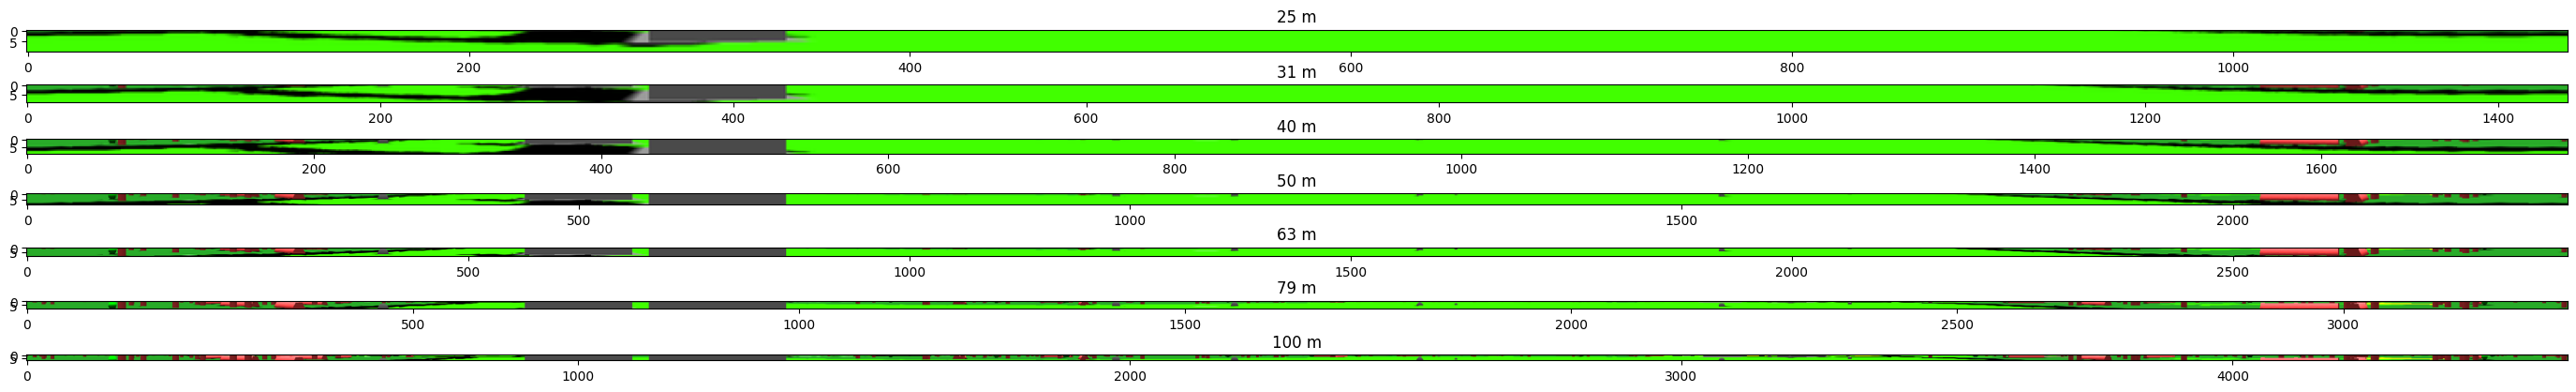

In [6]:
from fitam.mapping.spatial_label_general import calculate_footline_pixel_heights, ImagePyramid, create_image_pyramid

image_pyramid = create_image_pyramid(demo_pano, ImagePyramidConfig(min_range_m=25, max_range_m=100, image_slice_height_pixels=10))
fig, ax = plt.subplots(len(image_pyramid.image_slices), figsize=(35, 5))
for i, image_slice in enumerate(image_pyramid.image_slices):
    ax[i].imshow(image_slice)
    ax[i].set_title(f'{image_pyramid.footline_distances[i]:.0f} m')

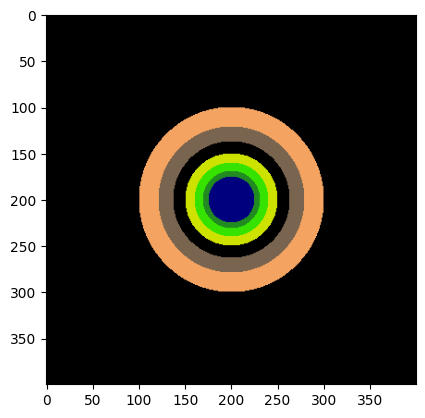

In [7]:
xx, yy = np.meshgrid(np.arange(-200, 200, 1), np.arange(-200, 200, 1))
r = np.sqrt(xx**2 + yy**2)
theta = np.arctan2(yy, xx)
semantic_map = np.zeros_like(r)
semantic_map[r < 100] = 7
semantic_map[r < 79] = 6
semantic_map[r < 63] = 5
semantic_map[r < 50] = 4
semantic_map[r < 40] = 3
semantic_map[r < 31] = 2
semantic_map[r < 25] = 1
class_map = { 1: 'water', 2: 'forest', 3: 'grass', 4: 'field', 5: 'road', 6: 'marsh', 7: 'beach'}
inv_class_map = {v: k for k, v in class_map.items()}
circle_world = LandCoverComplexMap(semantic_map, 1, inv_class_map)
plt.imshow(circle_world.create_floormask())

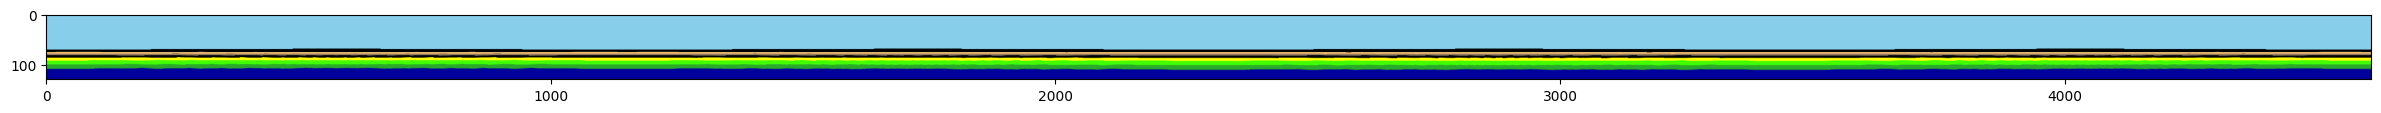

In [8]:
Image.fromarray((256 * circle_world.create_floormask()).astype(np.uint8)).save('/tmp/circle_world.png')
circle_world_scene = create_scene(circle_world, '/tmp/circle_world.png')
circle_world_pano = render_scene(circle_world_scene, [0, 0, 1.5], 0.0)
plt.figure(figsize=(30, 5))
plt.imshow(circle_world_pano)


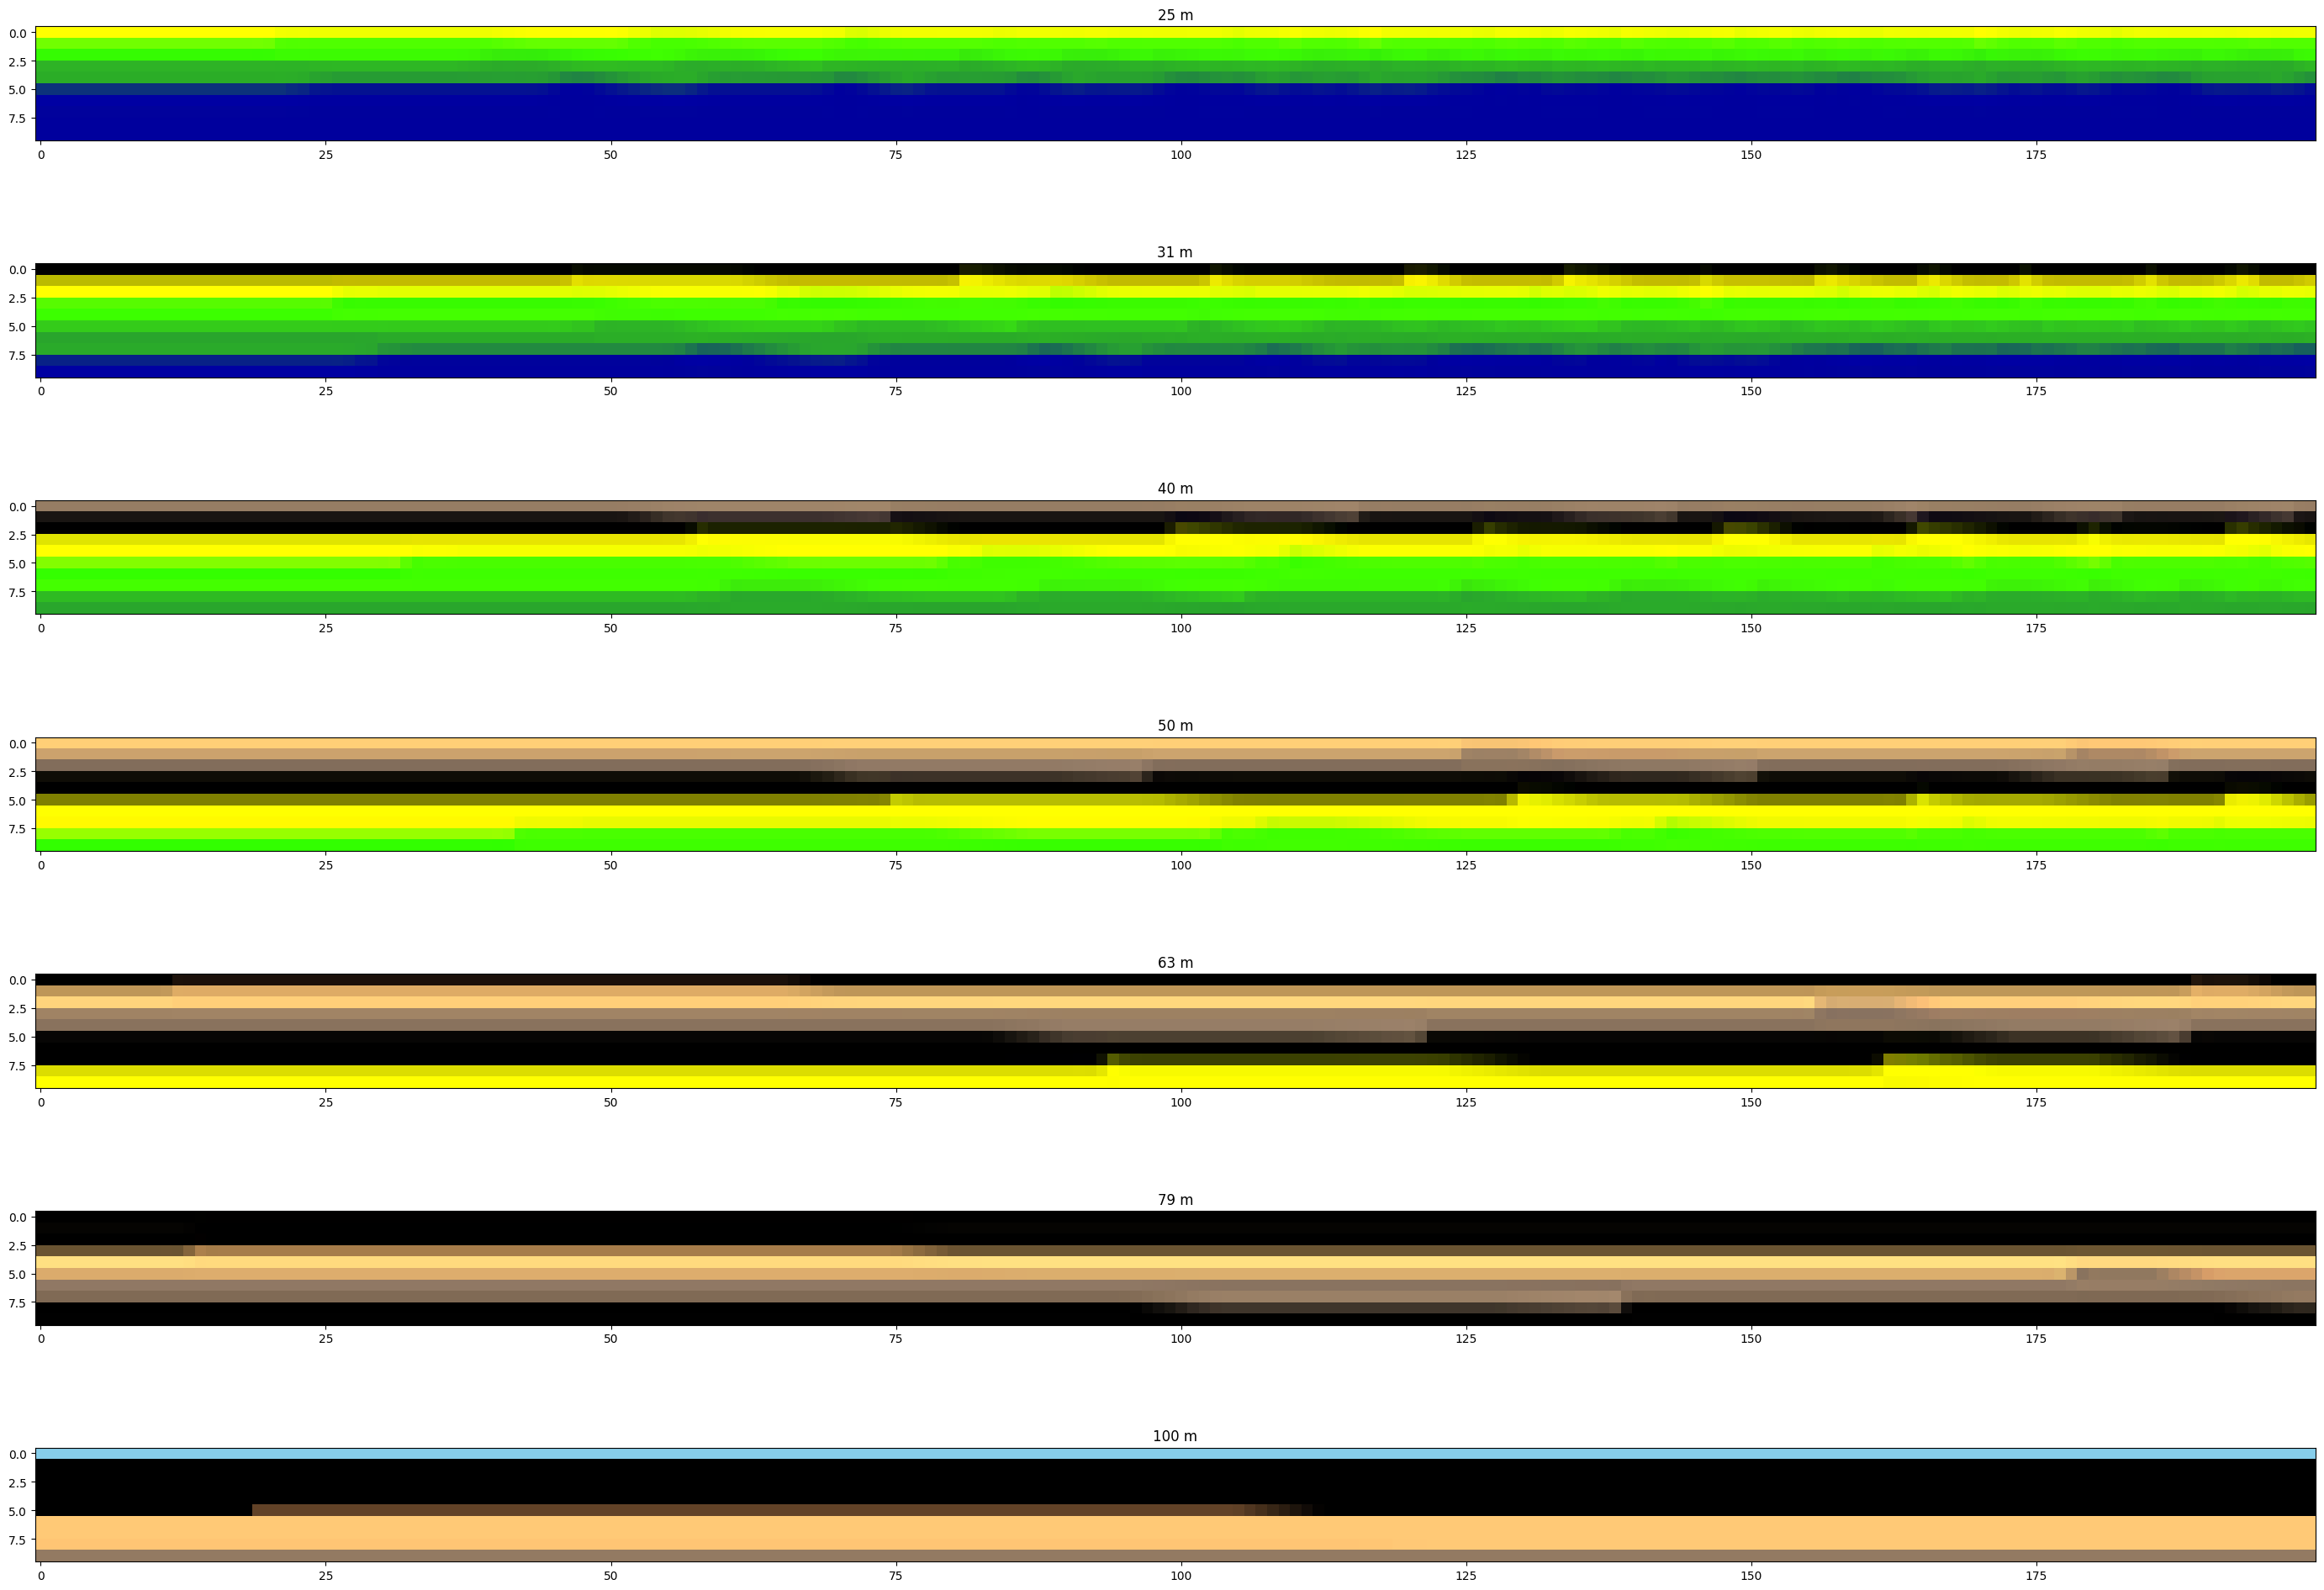

In [9]:
image_pyramid = create_image_pyramid(circle_world_pano, ImagePyramidConfig(min_range_m=25, max_range_m=100, image_slice_height_pixels=10))
fig, ax = plt.subplots(len(image_pyramid.image_slices), figsize=(35, 25))
for i, image_slice in enumerate(image_pyramid.image_slices):
    ax[i].imshow(image_slice[:, :200])
    ax[i].set_title(f'{image_pyramid.footline_distances[i]:.0f} m')

# Calculate Labels

In [10]:
from fitam.core.common import angle_between_lr_yaw
from fitam.mapping.spatial_label_general import image_pyramid_to_batch, find_yaw_from_range_yaw_percentage, find_xy_for_image_pyramid_batch

(868, 10, 20, 3)


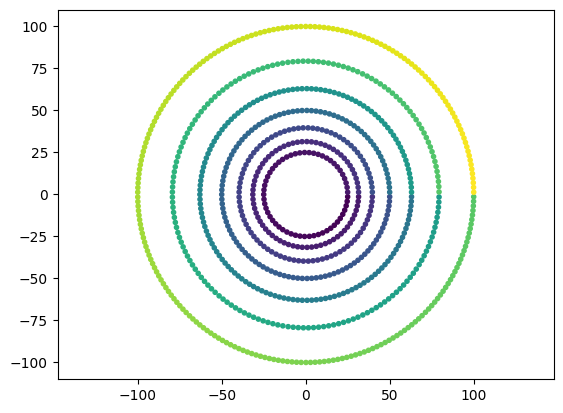

In [11]:
patches, patch_range_and_yaw_percentage = image_pyramid_to_batch(image_pyramid, 20)
robot_location_m = (0, 0)
lr_image_yaw_rad = (0, 2*np.pi)
xy_values = find_xy_for_image_pyramid_batch(robot_location_m, lr_image_yaw_rad, patch_range_and_yaw_percentage)
plt.figure()
plt.scatter(xy_values[:, 0], xy_values[:, 1], c=range(len(xy_values)), marker='.')
plt.axis('equal')
# plt.xlim([0, 100])
# plt.ylim([0, 100])

print(patches.shape)

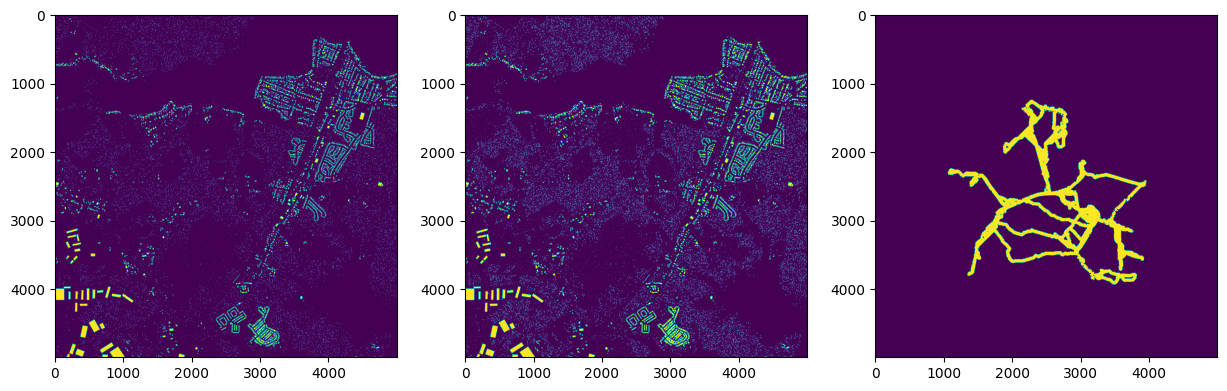

In [12]:
from fitam import IMAGES_DIR
from fitam.mapping.costmap import OccupancyGrid
import pandas as pd
from scipy.ndimage import binary_dilation

RADIUS_DIALATION_M = 1.0 # meters

images_dir = IMAGES_DIR / 'balt_standard'
image_info = pd.read_csv(images_dir / 'points.csv')

masked_map_path = MAPS_DIR / image_info.loc[0, 'map_path']
gt_map_path = MAPS_DIR / 'final_experiment_train_balt'
masked_map = LandCoverComplexMap.from_map_folder(masked_map_path)
gt_map = LandCoverComplexMap.from_map_folder(gt_map_path)

gt_obstacle_map = gt_map.create_occlusion_map()

num_iterations = int(RADIUS_DIALATION_M / gt_map.resolution)
dialated_obstacle_map = binary_dilation(gt_obstacle_map, iterations=num_iterations)
gt_occ_grid = OccupancyGrid(gt_map.resolution, width=gt_obstacle_map.shape[1], height=gt_obstacle_map.shape[0], data=dialated_obstacle_map)
observed_occ_grid = OccupancyGrid(gt_map.resolution, width=gt_obstacle_map.shape[1], height=gt_obstacle_map.shape[0], data=~masked_map.masks['unknown'])
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(gt_obstacle_map)
ax[1].imshow(dialated_obstacle_map.data)
ax[2].imshow(observed_occ_grid.data)


In [13]:
image_info.head()

,map_path,img_path,yaw_left,yaw_right,x,y,camera_name
0,training_map/masked_map,images/0009800_pano.png,0.0,6.283185,-797.0,-651.0,main
1,training_map/masked_map,images/0009801_pano.png,0.0,6.283185,-795.0,-649.0,main
2,training_map/masked_map,images/0009802_pano.png,0.0,6.283185,-793.0,-647.0,main
3,training_map/masked_map,images/0009803_pano.png,0.0,6.283185,-791.0,-645.0,main
4,training_map/masked_map,images/0009804_pano.png,0.0,6.283185,-789.0,-643.0,main


In [17]:
from fitam.mapping.spatial_label_general import label_image_pyramid_batch, ImagePatchDataset, create_one_batch_of_labels, create_image_pyramid_labels_from_images, balance_classes_in_dataset, save_image_patch_dataset

In [16]:
from pathlib import Path
import tqdm

In [17]:

# images_dir = IMAGES_DIR / 'balt_standard'

# masked_map_path = MAPS_DIR / 'training_map' / 'masked_map'
# gt_map_path = MAPS_DIR / 'final_experiment_train_balt'

# dataset = create_image_pyramid_labels_from_images(
#     images_dir,
#     masked_map_path,
#     gt_map_path,
#     ImagePyramidConfig()
# )

In [19]:
# print("Found a total of ", np.sum(dataset.labels == 1), "obstacles", "and", np.sum(dataset.labels == 0), "free cells in the unbalanced dataset")
# balanced_dataset = balance_classes_in_dataset(dataset, np.random.default_rng(42))
# print("Found a total of ", np.sum(balanced_dataset.labels == 1), "obstacles", "and", np.sum(balanced_dataset.labels == 0), "free cells in the unbalanced dataset")

In [22]:
# from fitam import DATASETS_DIR
# (DATASETS_DIR / 'spatial_label_propagation').mkdir(exist_ok=True, parents=True)
# save_image_patch_dataset(balanced_dataset, DATASETS_DIR / 'spatial_label_propagation' / 'balt_standard.h5')

# Visualize Parts of the Dataset

In [18]:
from fitam.mapping.spatial_label_general import visualize_dataset_sample

In [24]:
from fitam import DATASETS_DIR
# save_vis_path = DATASETS_DIR / 'spatial_label_propagation' / "visualizations"
# save_vis_path.mkdir(exist_ok=True)
# for i in tqdm.tqdm(range(0, len(balanced_dataset.labels), 1000)):
#     fig = visualize_dataset_sample(
#         # dataset,
#         balanced_dataset,
#         images_dir,
#         i, 
#         gt_map,
#         gt_occ_grid,
#         observed_occ_grid,
#         50
#     )
#     plt.savefig(save_vis_path / f"{i}.png")
#     plt.close(fig)

In [25]:
# investigation_index = 19000
# fig = visualize_dataset_sample(
#     balanced_dataset,
#     images_dir,
#     investigation_index, 
#     gt_map,
#     gt_occ_grid,
#     observed_occ_grid,
#     50
# )

# print("image path", balanced_dataset.image_paths[investigation_index])
# r = np.linalg.norm(np.asarray(balanced_dataset.robot_locations[investigation_index]) - np.asarray(balanced_dataset.xys[investigation_index]))
# theta = np.arctan2(balanced_dataset.xys[investigation_index][1] - balanced_dataset.robot_locations[investigation_index][1], 
#                    balanced_dataset.xys[investigation_index][0] - balanced_dataset.robot_locations[investigation_index][0])
# print("range is ", r, "headig is ", theta)
# print("Robot location is ", balanced_dataset.robot_locations[investigation_index])
# img = np.array(Image.open(images_dir / balanced_dataset.image_paths[investigation_index]))
# # plt.figure(figsize=(30, 3))
# # plt.imshow(img)
# img_pyramid = create_image_pyramid(img, ImagePyramidConfig())

# fig, ax = plt.subplots(len(img_pyramid.image_slices), figsize=(35, 25))
# for i, image_slice in enumerate(img_pyramid.image_slices):
#     ax[i].imshow(image_slice)
#     ax[i].set_title(f'{img_pyramid.footline_distances[i]:.0f} m')

In [26]:
# patches, labels, xys, ranges_and_yaw_percentage = create_one_batch_of_labels(
#     images_dir / balanced_dataset.image_paths[investigation_index],
#     balanced_dataset.robot_locations[investigation_index],
#     (0, 2 * np.pi),
#     gt_occ_grid,
#     observed_occ_grid,
#     ImagePyramidConfig()
# )

In [27]:
# ranges_and_thetas = ranges_and_yaw_percentage * np.asarray([1, 2 * np.pi])

In [28]:
# indexes = np.arange(len(ranges_and_thetas))
# range_mask = np.isclose(ranges_and_thetas[:, 0], r)
# bearing_mask = np.isclose(ranges_and_thetas[:, 1], theta, atol=0.05)
# ranges_and_thetas[range_mask & bearing_mask]
# close_patches = patches[range_mask & bearing_mask]
# print("xy\n", xys[range_mask & bearing_mask])
# print("labels\n", labels[range_mask & bearing_mask])
# fig, ax = plt.subplots(1, close_patches.shape[0], figsize=(12,3))
# for i in range(len(close_patches)):
#     ax[i].imshow(close_patches[i])
#     ax[i].set_title(f"{ranges_and_thetas[range_mask & bearing_mask][i][1]:.3f}")
# plt.show()

In [29]:
# i, j = gt_occ_grid.get_index_from_point(xys[range_mask & bearing_mask][0])
# print(gt_occ_grid.data[i, j])
# plt.imshow(gt_occ_grid.data[i-20:i+20, j-20:j+20])

# Train a Model

In [20]:
from fitam import DATASETS_DIR
import torch
import torch.nn as nn
import copy
import numpy as np 
import h5py
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms.v2 as v2

In [21]:

from fitam.learning.spatial_label_training import preprocess_image_pyramid_batch, H5ImagePatchDataset, SpatialLabelModel, evaluate, train_spatial_label_model

test_torch_dataset = H5ImagePatchDataset(DATASETS_DIR / 'spatial_label_propagation' / 'balt_standard.h5')

In [34]:
# best_model = train_spatial_label_model(DATASETS_DIR / 'spatial_label_propagation' / 'balt_standard.h5')

# Perform Inference and Construct Predicted Maps

In [99]:
import torch
from fitam import MODELS_DIR
from fitam.mapping.costmap_swath_library import SwathLibrary
from fitam.core.config.RadialMapConfig import FarFieldConfig
from fitam.core.common import floor_to_array, wrap_angle_2pi


from fitam.mapping.observation_types import SpatialLabelObservation

In [ ]:
model = SpatialLabelModel()
weights = torch.load(MODELS_DIR / 'spatial_label_propagation' / 'best_model.pt', weights_only=True)
model.load_state_dict(weights)

In [22]:
from fitam.mapping.spatial_label_general import pyramid_sizes_from_image_and_config, farfield_config_from_spatial_label

In [81]:
ff_config_spatial = farfield_config_from_spatial_label((128, 4608, 3), ImagePyramidConfig())
sl = SwathLibrary(25, 1.0, 0.001, ff_config_spatial, generate=True, show_progress=False)

In [82]:
# collect all inputs

image_pyramid_config = ImagePyramidConfig()
ff_config_spatial = farfield_config_from_spatial_label((128, 4608, 3), image_pyramid_config)
sl = SwathLibrary(25, 1.0, 0.001, ff_config_spatial, generate=True, show_progress=False)
robot_state = (0, 0)
left_yaw_rad = 1.5 
scene = demo_scene
device="cuda"
model = model.to(device)

In [107]:

# render image
pano = render_scene(scene, (robot_state[0], robot_state[1],image_pyramid_config.camera_height_m), left_yaw_rad)

# split image into image pyramid 
image_pyramid = create_image_pyramid(pano, image_pyramid_config)
batch, range_and_yaw_percentage = image_pyramid_to_batch(image_pyramid, image_pyramid_config.image_slice_width_pixels)
model_inputs = preprocess_image_pyramid_batch(batch, device)
# run inference on all slices
patch_classes = model(model_inputs).argmax(dim=1).cpu().numpy()
# map inference results to radial bins

range_and_yaw_percentage[:, 1] = find_yaw_from_range_yaw_percentage(range_and_yaw_percentage, (left_yaw_rad, left_yaw_rad - 2 * np.pi))
obs = SpatialLabelObservation((128, 128), patch_classes, range_and_yaw_percentage, left_yaw_rad, sl, 0.0)

In [ ]:
kalman_obs.cost

In [ ]:
kalman_obs = obs.to_kalman_observation(((256, 256)))
arr = np.zeros((256,256))
arr[kalman_obs.i, kalman_obs.j] = kalman_obs.cost
plt.imshow(arr)

In [ ]:
map_crop = demo_map.create_floormask()[2500-128:2500+128,2500-128:2500+128]
map_crop[arr > 0, 0] += 100
plt.imshow(map_crop)

In [93]:
from fitam import FITAM_ROOT_DIR
for i in range(len(patches)):
    fig = plt.figure()
    plt.imshow(batch[i])
    plt.savefig(FITAM_ROOT_DIR + f"/scratch/{i:05d}.png")
    plt.close(fig)


In [ ]:
np.argmax(patch_classes)
plt.figure(figsize=(24,3))
plt.imshow(pano)